# Recommender System Starter

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Load module from another directory
import shutil
shutil.copyfile(src="../scripts/redcarpet.py", dst="../notebooks/redcarpet.py")
from redcarpet import mat_to_sets

## Load Data

In [3]:
item_file = "../input/talent.pkl"
item_records, COLUMN_LABELS, READABLE_LABELS, ATTRIBUTES = pickle.load(open(item_file, "rb"))
item_df = pd.DataFrame(item_records)[ATTRIBUTES + COLUMN_LABELS].fillna(value=0)
ITEM_NAMES = item_df["name"].values
ITEM_IDS = item_df["id"].values
s_items = mat_to_sets(item_df[COLUMN_LABELS].values)
assert len(item_df) == len(s_items), "Item matrix is not the same length as item category set list."
print("Talent:", len(item_df))
print("Categories:", len(COLUMN_LABELS))
item_df.head()

Talent: 5392
Categories: 103


,id,name,price,reactions,stars,joined,categories,in_13_reasons_why,in_90_day_fiance,in_actors,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"[Reality TV, Commentators, Featured]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,andydick,Andy Dick,99.0,340,4.9,October 2018,"[Reality TV, Comedians, Featured, Actors]",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tjlavin,TJ Lavin,80.0,291,5.0,February 2018,"[Reality TV, Riders, Featured, Extreme Sports,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,carsonkressley,Carson Kressley,59.0,290,5.0,October 2018,"[Reality TV, Bravo, Stylists, Featured, Actors...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,riffraff,RiFF RAFF,75.0,402,4.7,December 2017,"[Rappers, Featured, Musicians]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def cameo_name(i):
    """
    Show the name and URL of Cameo talent based on its index `i`.
    """
    return "{} (cameo.com/{})".format(ITEM_NAMES[i], ITEM_IDS[i])

In [5]:
csr_train, csr_test, csr_input, csr_hidden = pickle.load(open("../input/train_test_mat.pkl", "rb"))
m_split = [np.array(csr.todense()) for csr in [csr_train, csr_test, csr_input, csr_hidden]]
m_train, m_test, m_input, m_hidden = m_split
s_train, s_test, s_input, s_hidden = pickle.load(open("../input/train_test_set.pkl", "rb"))
assert len(m_train) == len(s_train), "Train matrix is not the same length as train sets."
assert len(m_test) == len(s_test), "Test matrix is not the same length as test sets."
assert len(m_input) == len(s_input), "Input matrix is not the same length as input sets."
assert len(m_hidden) == len(s_hidden), "Hidden matrix is not the same length as hidden sets."
print("Train Users", len(m_train))
print("Test Users", len(m_test))
print("Minimum Test Items per User:", min(m_test.sum(axis=1)))
print("Minimum Input Items per User:", min(m_input.sum(axis=1)))
print("Minimum Hidden Items per User:", min(m_hidden.sum(axis=1)))
like_df = pd.DataFrame(m_train, columns=ITEM_NAMES)
like_df.head()

Train Users 3000
Test Users 1000
Minimum Test Items per User: 23
Minimum Input Items per User: 7
Minimum Hidden Items per User: 16


,Perez Hilton,Andy Dick,TJ Lavin,Carson Kressley,RiFF RAFF,Chumlee,Gilbert Gottfried,Ice T,Ben Higgins,Evan Breen,...,Chris Jai Alex,Peter Dickson,Laura Perlongo,Anna del Gaizo,Zach Harper,John Oberg,Zac Pullam,Kansas Bowling,Matt Cirulnick,Caleb Senzel
0,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Evaluation Metrics

In [6]:
from redcarpet import mapk_score, uhr_score

In [7]:
help(mapk_score)

Help on function mapk_score in module redcarpet:

mapk_score(s_hidden, recs_pred, k=10)
    Computes the mean average precision at k (MAP@K) of recommendations.
    MAP@K = mean AP@K score over all users
    AP@K = (1 / min(m, k)) * sum from 1 to k of (precision at i * relevance of ith item)
    Where m is the number of items in a user's hidden set
    Where k is the number of items recommended to each user
    params:
        s_hidden: list of sets of hidden items for each user
        recs_pred: list of lists of recommended items, with each list
        k: number of recommendations to use in top set
    returns:
        float, range [0, 1]



In [8]:
help(uhr_score)

Help on function uhr_score in module redcarpet:

uhr_score(s_hidden, recs_pred, k=10)
    Computes the user hit tate (UHR) score of recommendations.
    UHR = the fraction of users whose top list included at
    least one item also in their hidden set.
    params:
        s_hidden: list of sets of hidden items for each user
        recs_pred: list of lists of recommended items, with each list
        k: number of recommendations to use in top set
    returns:
        float, range [0, 1]



## Similarity Measures

In [9]:
from redcarpet import jaccard_sim, cosine_sim

In [10]:
help(jaccard_sim)

Help on function jaccard_sim in module redcarpet:

jaccard_sim(u, v)
    Computes the Jaccard similarity between sets u and v.
    sim = intersection(u, v) / union(u, v)
    params:
        u, v: sets to compare
    returns:
        float between 0 and 1, where 1 represents perfect
            similarity and 0 represents no similarity



In [11]:
help(cosine_sim)

Help on function cosine_sim in module redcarpet:

cosine_sim(u, v)
    Computes the Cosine similarity between sets u and v.
    sim = intersection(u, v) / sqrt(|u| * |v|)
    Where |s| is the number of items in set s
    params:
        u, v: sets to compare
    returns:
        float between 0 and 1, where 1 represents perfect
            similarity and 0 represents no similarity



## Recommendation Algorithms

In [12]:
from redcarpet import collaborative_filter, content_filter, weighted_hybrid

In [13]:
help(collaborative_filter)

Help on function collaborative_filter in module redcarpet:

collaborative_filter(s_train, s_input, j=3, sim_fn=None, threshold=0.01, k=10)
    Collaborative filtering recommender system.
    params:
        s_train: list of sets of liked item indices for train data
        s_input: list of sets of liked item indices for input data
        j: number of similar users to base recommendations on
        sim_fn(u, v): function that returns a float value representing
            the similarity between sets u and v
        threshold: minimum similarity required to consider a similar user
        k: number of items to recommend for each user
    returns:
        recs_pred: list of lists of tuples of recommendations where
            each tuple has (item index, relevance score) with the list
            of tuples sorted in order of decreasing relevance



In [14]:
help(content_filter)

Help on function content_filter in module redcarpet:

content_filter(items_train, s_input, sim_fn=None, threshold=0.01, k=10)
    Content-based filtering recommender system.
    params:
        items_train: list of sets of non-zero attribute indices for items
        s_input: list of sets of liked item indices for input data
        sim_fn(u, v): function that returns a float value representing
            the similarity between sets u and v
        threshold: minimum similarity required to consider a similar item
        k: number of items to recommend for each user
    returns:
        recs_pred: list of lists of tuples of recommendations where
            each tuple has (item index, relevance score) with the list
            of tuples sorted in order of decreasing relevance



In [15]:
help(weighted_hybrid)

Help on function weighted_hybrid in module redcarpet:

weighted_hybrid(components, use_ranks=False, k=10)
    Hybrid recommender system using weights.
    params:
        components: list of tuples where each tuple has (recs list, weight)
            where recs_list is a list of tuples where each tuple has
            (item index, relevance score) and weight is the factor used to
            scale the relevance scores for this component
        use_ranks: boolean (default: False), if True, apply weights to the
            inverse rank of each item instead of its score, for example:
            the first recommended item will earn 1 * weight, the second will
            earn 1/2 * weight, the third will earn 1/3 * weight and so on
        k: number of items to recommend for each user
    returns:
        recs_pred: list of lists of tuples of recommendations where
            each tuple has (item index, relevance score) with the list
            of tuples sorted in order of decreasing re

## Model Selection

In [16]:
from redcarpet import get_recs
from redcarpet import show_user_recs, show_item_recs, show_user_detail
from redcarpet import show_apk_dist, show_hit_dist, show_score_dist

In [17]:
help(get_recs)

Help on function get_recs in module redcarpet:

get_recs(user_recs, k=None)
    Extracts recommended item indices, leaving out their scores.
    params:
        user_recs: list of lists of tuples of recommendations where
            each tuple has (item index, relevance score) with the
            list of tuples sorted in order of decreasing relevance
        k: maximumum number of recommendations to include for each
            user, if None, include all recommendations
    returns:
        list of lists of recommendations where each
            list has the column indices of recommended items
            sorted in order they appeared in user_recs



In [18]:
k_top = 10

In [19]:
print("Model: Collaborative Filtering with Jacccard Similarity (j=10)")
collab_jac10 = collaborative_filter(s_train, s_input, sim_fn=jaccard_sim, j=10, k=k_top)
print("MAP = {0:.3f}".format(mapk_score(s_hidden, get_recs(collab_jac10), k=k_top)))
print("UHR = {0:.3f}".format(uhr_score(s_hidden, get_recs(collab_jac10), k=k_top)))

Model: Collaborative Filtering with Jacccard Similarity (j=10)
MAP = 0.349
UHR = 0.985


Use `show_item_recs()` to get a Pandas dataframe of every item that was recommended.

In [20]:
idf = show_item_recs(s_hidden, collab_jac10, k=k_top)
idf.sort_values(by=["Hits", "Hit Rate"], ascending=[False, False]).head()

,Item,Recommended,Hits,Hit Rate,Avg Score
11,9,665,429,0.645113,0.661955
20,0,516,259,0.501938,0.522093
12,11,520,218,0.419231,0.538846
10,149,425,151,0.355294,0.475059
13,12,406,133,0.327586,0.471429


Use `show_user_recs` to get a Pandas dataframe of the recommendations for every user.

In [21]:
udf = show_user_recs(s_hidden, collab_jac10, k=k_top)
udf.sort_values(by=["APK", "Hits"], ascending=[False, False]).head()

,User,APK,Hits
21,21,1.0,10
42,42,1.0,10
62,62,1.0,10
72,72,1.0,10
108,108,1.0,10


Use `show_user_detail` to look at the recommendations for a user in more detail.

In [22]:
show_user_detail(s_input, s_hidden, collab_jac10, uid=0, name_fn=cameo_name)

User: 0
Given:       [2289, 2513, 2517, 2551, 2569, 2592, 4809]
Recommended: [2259, 2526, 2574, 2593, 4805, 4807, 4808, 4810, 4813, 4815]
Actual:      [0, 1, 3, 5, 7, 8, 9, 13, 42, 49, 58, 63, 66, 105, 147, 149, 150, 189, 192, 227, 312, 392, 1383, 1618, 1664, 2511, 2521, 2522, 2526, 2528, 2530, 2533, 2534, 2535, 2537, 2543, 2546, 2550, 2554, 2558, 2573, 2581, 2584, 2586, 2587, 2588, 2589, 2593, 2762, 2866, 4805, 4806, 4807, 4808, 4810, 4811, 4812, 4814, 4815, 4816, 5337, 5346, 5350, 5372]

Recommendation Hits = 7
Average Precision   = 0.531

All Recommendation Scores:
01. [Y] (1.000) Jackie Mark Goldschneider (cameo.com/jackie_goldschneider)
02. [Y] (1.000) D'Andra Simmons (cameo.com/dandrasimmons)
03. [ ] (1.000) Lauri Peterson (cameo.com/lauri_peterson)
04. [Y] (1.000) Candiace Dillard Bassett (cameo.com/realcandiacedbassett)
05. [ ] (1.000) Kristen Taekman (cameo.com/kristentaekman)
06. [ ] (0.900) Gina Kirschenheiter (cameo.com/ginakirschenheiter)
07. [Y] (0.900) Katie Rost (cameo.

In [23]:
print("Model: Collaborative Filtering with Cosine Similarity (j=10)")
collab_cos10 = collaborative_filter(s_train, s_input, sim_fn=cosine_sim, j=10, k=k_top)
print("MAP = {0:.3f}".format(mapk_score(s_hidden, get_recs(collab_cos10), k=k_top)))
print("UHR = {0:.3f}".format(uhr_score(s_hidden, get_recs(collab_cos10), k=k_top)))

Model: Collaborative Filtering with Cosine Similarity (j=10)
MAP = 0.388
UHR = 0.981


Compare multiple models by plotting the distributions of the AP@K scores, hit counts, and item scores.

In [24]:
results = [
    (collab_jac10, "Jaccard (j=10)"),
    (collab_cos10, "Cosine (j=10)")
]

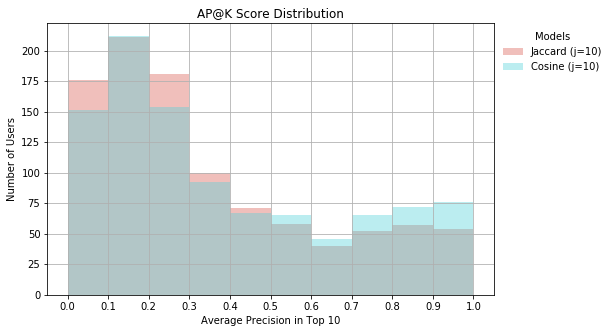

In [25]:
show_apk_dist(s_hidden, results, k=k_top)

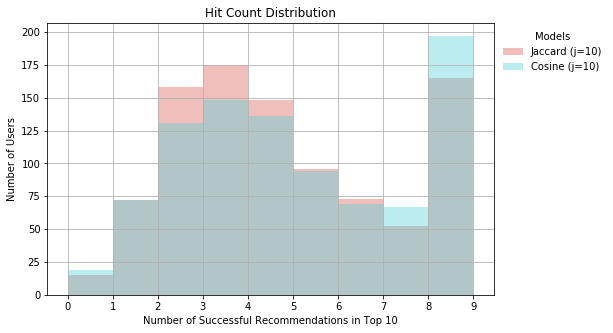

In [26]:
show_hit_dist(s_hidden, results, k=k_top)

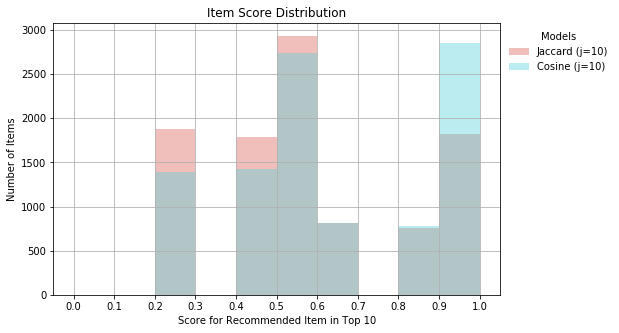

In [27]:
show_score_dist(results, k=10, bins=np.arange(0.0, 1.1, 0.1))

In [28]:
print("Model: Hybrid Collaborative Filtering")
print("Similarity: Hybrid (0.2 * Jaccard + 0.8 * Cosine)")
collab_hybrid = weighted_hybrid([
    (collab_jac10, 0.2),
    (collab_cos10, 0.8)
])
print("MAP = {0:.3f}".format(mapk_score(s_hidden, get_recs(collab_hybrid), k=k_top)))
print("UHR = {0:.3f}".format(uhr_score(s_hidden, get_recs(collab_hybrid), k=k_top)))

Model: Hybrid Collaborative Filtering
Similarity: Hybrid (0.2 * Jaccard + 0.8 * Cosine)
MAP = 0.389
UHR = 0.981


## Submit to Kaggle

In [29]:
from redcarpet import write_kaggle_recs, download_kaggle_recs

In [30]:
# Load hold out set
s_hold_input = pickle.load(open("../input/hold_set.pkl", "rb"))
print("Hold Out Set: N = {}".format(len(s_hold_input)))
s_all_input = s_input + s_hold_input
print("All Input:    N = {}".format(len(s_all_input)))

Hold Out Set: N = 1000
All Input:    N = 2000


In [31]:
print("Final Model")
print("Strategy: Collaborative")
print("Similarity: Cosine (j=10)")
# Be sure to use the entire s_input
final_scores = collaborative_filter(s_train, s_all_input, sim_fn=cosine_sim, j=10)
final_recs = get_recs(final_scores)

Final Model
Strategy: Collaborative
Similarity: Cosine (j=10)


In [33]:
outfile = "../output/kaggle_submission_hybrid_collab.csv"
n_lines = write_kaggle_recs(final_recs, outfile)
print("Wrote predictions for {} users to {}.".format(n_lines, outfile))
download_kaggle_recs(final_recs, outfile)

Wrote predictions for 2000 users to ../output/kaggle_submission_hybrid_collab.csv.
